In [0]:
%cd /content
!7z x dataset.7z

/content

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 17481629 bytes (17 MiB)

Extracting archive: dataset.7z
--
Path = dataset.7z
Type = 7z
Physical Size = 17481629
Headers Size = 3906
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     30% 251 - dataset/images/class_140.jpg                                        60% 297 - dataset/images/class_182.jpg                                        90% 342 - dataset/images/class_43.jpg                                      Everything is Ok

Folders: 4
Files: 400
Size:       17671022
Com

In [0]:
!git clone https://github.com/tensorflow/models.git

# Ставим компоненты, которые потребуются в процессе работы
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools
!pip install wget

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

# Обновляем переменные окружения
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

# Проверяем корректность установки. В тестах должны быть [       OK ]
!python object_detection/builders/model_builder_test.py

Cloning into 'models'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 32448 (delta 169), reused 209 (delta 103), pack-reused 32057
Receiving objects: 100% (32448/32448), 511.74 MiB | 30.93 MiB/s, done.
Resolving deltas: 100% (20478/20478), done.
Checking out files: 100% (3168/3168), done.
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=b0b0940b714d306f29e89ae5e20f9c2f9dfbc27e2c99a2670c7cdc9f0e54f70a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you dep

In [0]:
%cd /content/dataset

# Список классов (1 класс: CLASS)
!echo "item { id: 1 name: 'class'}" > label_map.pbtxt

# Сформируем список файлов, участвующих в обучении. Запишем его в файл trainval.txt
image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

%cd /content/dataset/annotations
!mkdir trimaps

# Создание пустых файлов для хранения масок
from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

%cd /content/dataset
# Компилируем DATASET в один файл
!python /content/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record
!mv pet_faces_val.record-00000-of-00001 tf_val.record

/content/dataset
/content/dataset/annotations
/content/dataset


W1113 14:00:25.288912 139954426238848 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

I1113 14:00:25.289963 139954426238848 create_pet_tf_record.py:273] Reading from Pet dataset.
I1113 14:00:25.290911 139954426238848 create_pet_tf_record.py:288] 140 training and 60 validation examples.

W1113 14:00:25.291134 139954426238848 module_wrapper.py:139] From /content/models/research/object_detection/dataset_tools/tf_record_creation_util.py:43: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I1113 14:00:25.291434 139954426238848 create_pet_tf_record.py:241] On image 0 of 140
/content/models/research/object_detection/utils/dataset_util.py:79: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not No

In [0]:
%cd /content/dataset

import os
import shutil
import glob
import urllib
import tarfile
import wget

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  wget.download(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)


tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/dataset


In [0]:
import re
filename = '/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/dataset/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/content/dataset/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/content/dataset/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/content/dataset/label_map.pbtxt', s)
  f.write(s)

In [0]:
%cd /content/dataset

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/content/dataset/trained \
    --alsologtostderr \
    --num_train_steps=1000 \
    --num_eval_steps=500

In [0]:
%cd /content/dataset

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/content/dataset
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1113 14:22:28.955351 139706238818176 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1113 14:22:28.961455 139706238818176 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:389: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1113 14:22:28.961804 139706238818176 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.compat.v1

In [0]:
%cd /content/dataset

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/content/dataset


Saving t7.jpg to t7.jpg
saved file t7.jpg


/content/models/research/object_detection


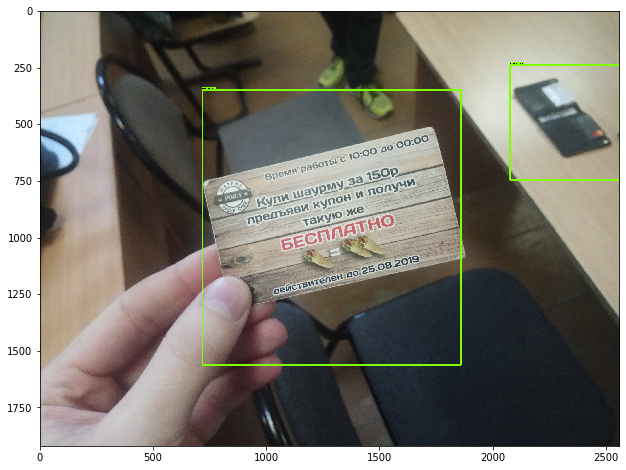

In [0]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
 
# This is needed to display the images.
%matplotlib inline

from utils import label_map_util
from utils import visualization_utils as vis_util

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/dataset/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/dataset/', 'label_map.pbtxt')
NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/dataset/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)